# Simulation for Salt intrusion


First the nessecary python packages are imported. This is a combination of open source packages (numpy, pygimli, ..) and code developed by Deltares (ert_inversion)

In [1]:
import os
import subprocess
from importlib import resources
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pygimli as pg
from pygimli.meshtools import appendTriangleBoundary, readGmsh
from pygimli.physics import ert

from ertoolbox import MPT, inversion


Set the data folder belonging to the ERToolbox package and also set some plotting settings


In [2]:
data_folder = Path(resources.files("ertoolbox.data"))

figsize = (12, 4)
cmin = 0.01
cmax = 3
aspect = 'auto'
cmap = 'viridis'

## Mesh

To be able to simulate for the real geometry of the field measurements, the inversion mesh is created using GMSH and imported using Pygimli. The input file is .geo file and is rewritten into a .msh. After importing the mesh, the prior resistivity values are set in the K value per mesh domain. 

Creating a working mesh is very important, some key aspects that are vital for the inversion to work are:
- mesh should consists of points, lines, line loops and a plane surface, that are also made 'physical'
- line loop should be a closed loop
- electrode positions should be a point defined in the input file
- if you cannot make the mesh in gmsh already, the geometry is corrupt

We use 2 files. 1 file only has 1 fixed conductivity in the inversion domain. The other one has a fresh-salt transition and uses 6 different conductivities. 


The .geo file in imported, translated to .msh and filled with K values in this part of the code:

Reading C:\Users\nieboer\gitclones\SaltSimulator\ertoolbox\data\kornwerderzand_1l_electrodes.msh... 

  Nodes: 4874
  Entries: 9943
    Points: 197
    Lines: 856
    Triangles: 8890
    Quads: 0
    Tetrahedra: 0 

Creating mesh object... 

  Dimension: 2-D
  Boundary types: 1 (-1,)
  Regions: 1 (2,)
  Marked nodes: 197 (999,)

Done. 

  Mesh: Nodes: 4874 Cells: 8890 Boundaries: 13763


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>,
 <matplotlib.colorbar.Colorbar at 0x2b512b78350>)

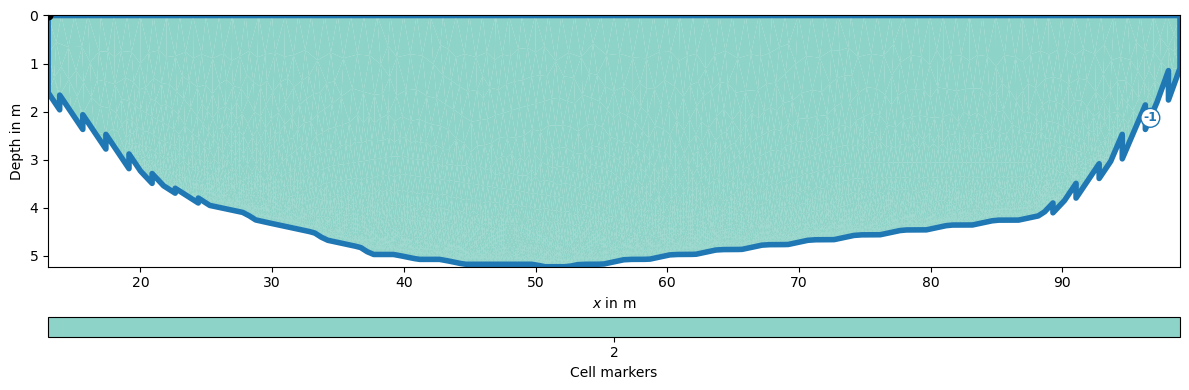

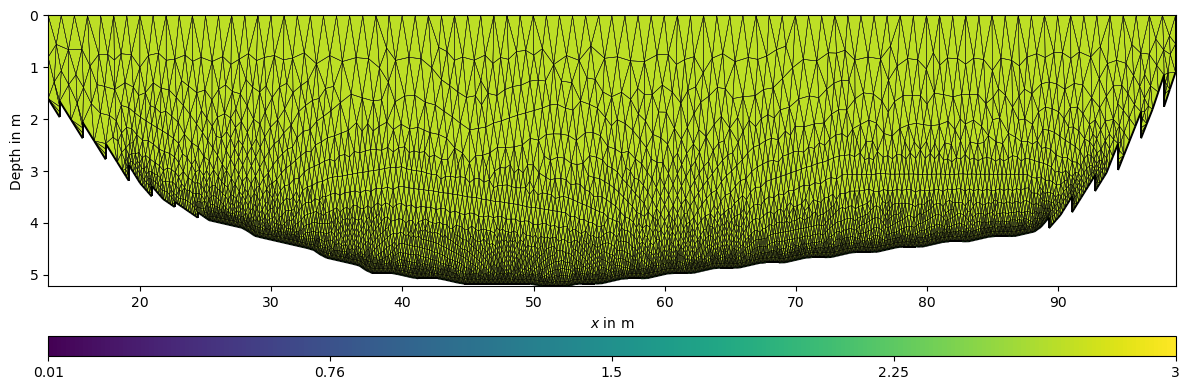

In [3]:
filename_1l = data_folder / "kornwerderzand_1l_electrodes.geo"
meshname_1l = filename_1l.with_suffix(".msh")

geom_1l = subprocess.call(["gmsh", "-format", "msh2", "-2", "-o", meshname_1l, filename_1l], shell=True)
mesh_1l = readGmsh(meshname_1l, verbose=True)

K_1l= [[2,2.7]]

pg.show(mesh_1l, markers=True, clipBoundaryMarkers=True, figsize=(12,4), aspect=aspect)
pg.show(mesh_1l, data = K_1l, clipBoundaryMarkers=True, showMesh=True, figsize=(12,4), aspect=aspect, cMin = cmin, cMax = cmax, cMap = cmap)

Reading C:\Users\nieboer\gitclones\SaltSimulator\ertoolbox\data\kornwerderzand_6l_electrodes.msh... 

  Nodes: 7459
  Entries: 14060
    Points: 0
    Lines: 0
    Triangles: 14060
    Quads: 0
    Tetrahedra: 0 

Creating mesh object... 

  Dimension: 2-D
  Regions: 6 (100, 200, 300, 400, 500, 600)

Done. 

  Mesh: Nodes: 7459 Cells: 14060 Boundaries: 21518


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>,
 <matplotlib.colorbar.Colorbar at 0x2b51a68e910>)

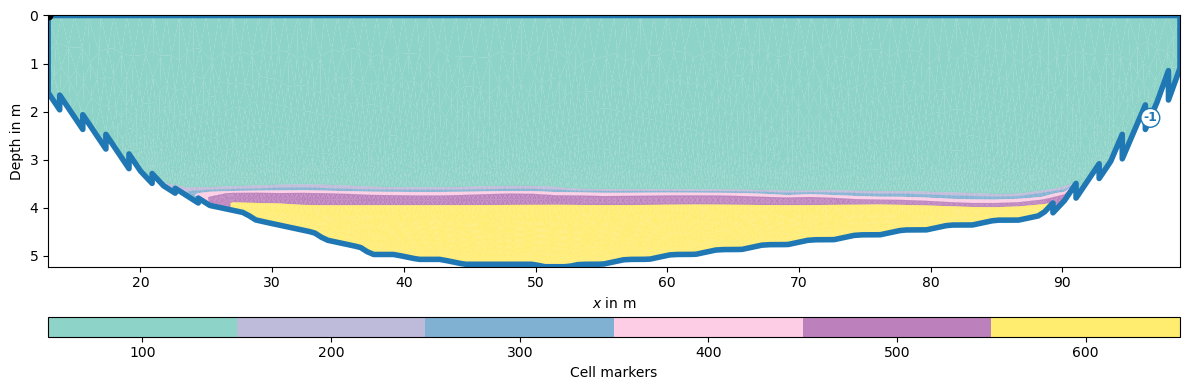

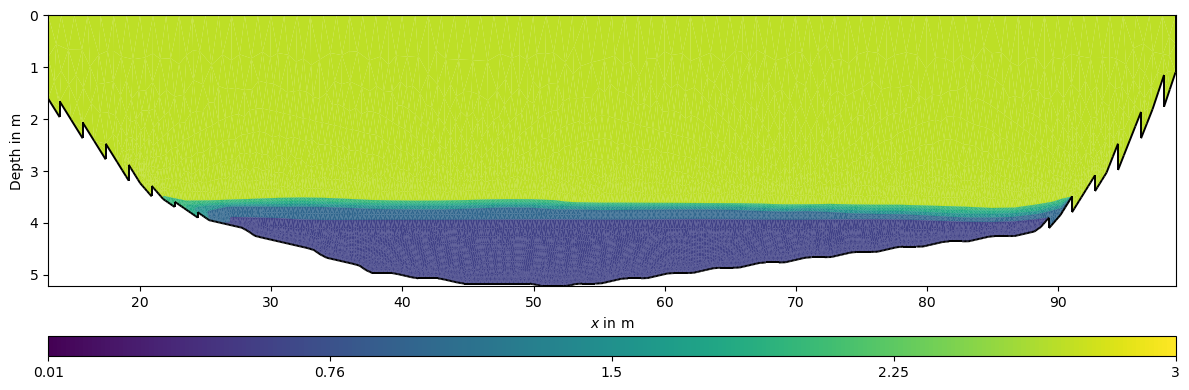

In [4]:
filename_6l = data_folder / "kornwerderzand_6l_electrodes.geo"
meshname_6l = filename_6l.with_suffix(".msh")

geom_6l = subprocess.call(["gmsh", "-format", "msh2", "-2", "-o", meshname_6l, filename_6l], shell=True)
mesh_6l = readGmsh(meshname_6l, verbose=True)

K_6l= [[100,2.7],[200,2],[300,1.8],[400,1.5],[500,1],[600,0.6] ]

pg.show(mesh_6l, markers=True, clipBoundaryMarkers=False, figsize=(12,4), aspect=aspect)
pg.show(mesh_6l, data =K_6l, clipBoundaryMarkers=False, figsize=(12,4), aspect=aspect, cMin = cmin, cMax = cmax, cMap=cmap)


for the inversion, we use a clean mesh.

Reading C:\Users\nieboer\gitclones\SaltSimulator\ertoolbox\data\kornwerderzand_1l_inversion_electrodes.msh... 

  Nodes: 4874
  Entries: 9943
    Points: 197
    Lines: 856
    Triangles: 8890
    Quads: 0
    Tetrahedra: 0 

Creating mesh object... 

  Dimension: 2-D
  Boundary types: 1 (-1,)
  Regions: 1 (2,)
  Marked nodes: 197 (999,)

Done. 

  Mesh: Nodes: 4874 Cells: 8890 Boundaries: 13763


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>, None)

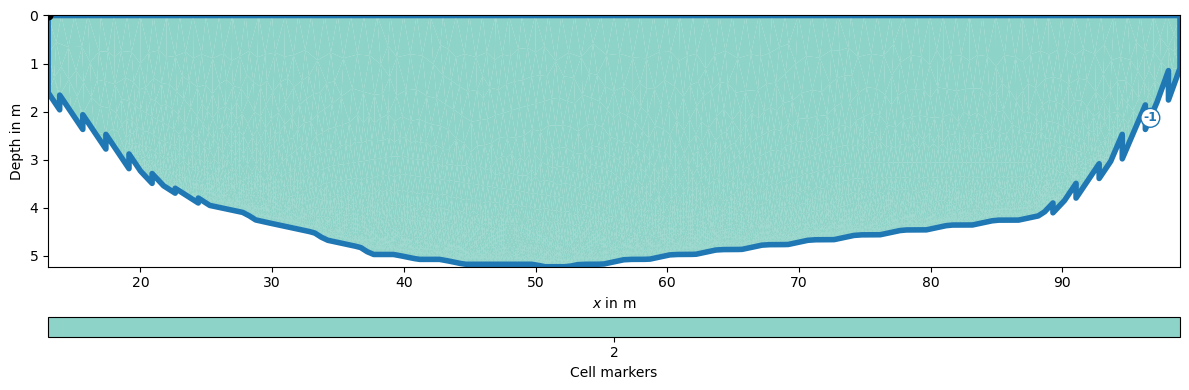

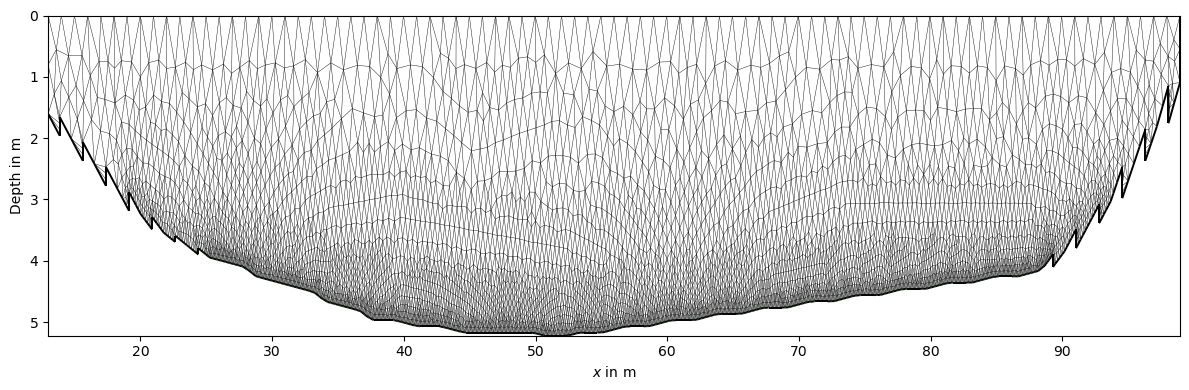

In [5]:
filename = data_folder / "kornwerderzand_1l_inversion_electrodes.geo" # lc = 0.5 m

inversion_mesh = filename.with_suffix(".msh")

geom = subprocess.call(["gmsh", "-format", "msh2", "-2", "-o", inversion_mesh, filename])
mesh = readGmsh(inversion_mesh, verbose=True)

pg.show(mesh, markers=True, clipBoundaryMarkers=True, figsize=(12,4), aspect=aspect)
pg.show(mesh, clipBoundaryMarkers=True, showmesh=True, figsize=(12,3), aspect=aspect)

## Simulate data

Using the custom mesh, we can make simulation data. This consists of the electrode positions and the inversion scheme. 3 schemes are shown here: dipole-dipole (dd), multiple gradient(gr) and one costom made mesh that was used in the field test.

Other possible standard configurations are: 
Wenner Alpha (C-P-P-C) :  wa
Wenner Beta(C-C-P-P) :  wb
Dipole Dipole (CC-PP) :  dd
Schlumberger(C-PP-C) :  slm
Pole Pole (C-P) :  pp
Pole Dipole (C-PP) :  pd
Half Wenner (C-P-P) :  hw
MultipleGradient(C--P-P--C) :  gr


first, the electrode positions are defined:

In [6]:

def add_evenly_spaced_points_overall(coords, spacing, number_of_electrodes, start_index=13):
    """
    Adds evenly spaced points along the entire line connecting the given coordinates.

    Parameters:
        coords (list of tuple): List of (x, y) coordinates representing the original points.
        spacing (float): Desired spacing between points.
        number_of_electrodes (int): Number of points to add.
        start_index (int): Index to start adding points from.

    Returns:
        list of tuple: List of (x, y) coordinates including the original and added points.
    """
    if start_index >= len(coords):
        raise ValueError("start_index is out of bounds of the coordinates list")

    new_coords = [coords[start_index]]
    total_length = sum(np.hypot(coords[i+1][0] - coords[i][0], coords[i+1][1] - coords[i][1]) for i in range(start_index, len(coords) - 1))

    if number_of_electrodes * spacing > total_length:
        raise ValueError("number_of_electrodes times the spacing exceeds the total line length. Reduce number_of_electrodes.")

    for i in range(1, number_of_electrodes + 1):
        dist_along_line = i * spacing
        remaining_dist = dist_along_line

        for j in range(start_index, len(coords) - 1):
            x1, y1 = coords[j]
            x2, y2 = coords[j + 1]
            segment_length = np.hypot(x2 - x1, y2 - y1)

            if remaining_dist <= segment_length:
                t = remaining_dist / segment_length
                new_x = x1 + t * (x2 - x1)
                new_y = y1 + t * (y2 - y1)
                new_coords.append((new_x, new_y))
                break
            else:
                remaining_dist -= segment_length

    return new_coords



## Choosing electrode spacing and  number

- For numerical stability, the positions of the electrodes were 'imprinted' onto the mesh. 
- The maximum amount of electrodes that can be used is 128 with a spacing of 0.5 m
- You can make a selection within these to run the simulation and inversion, but it should be a selection of the 'imprinted' points.
- The safest was to do this, is to keep below spacing and number_electrodes on 0.5 and 128 respectively and make a selection from this.
- OR: carefully use multiples, so spacing of 1 m with 64 electrodes, 2 m with 32 electrodes, etc.


[(25.268571428571427, -3.948765306122449), (25.76772921768727, -3.977773952505621), (26.266887006803113, -4.006782598888793), (26.766044795918955, -4.035791245271965), (27.265202585034796, -4.064799891655137), (27.76436037415064, -4.093808538038309), (28.25871638611043, -4.16426744601094), (28.751286257478203, -4.250144811019039), (29.25010368431133, -4.2820915582751296), (29.749261473427172, -4.311100204658302), (30.248419262543013, -4.340108851041474), (30.74757705165886, -4.369117497424646), (31.2467348407747, -4.398126143807818), (31.745892629890545, -4.42713479019099), (32.24505041900638, -4.456143436574162), (32.74420820812223, -4.485152082957334), (33.2422913153421, -4.523437679158425), (33.73486118670987, -4.609315044166523), (34.22995151828292, -4.673435103194152), (34.72910930739876, -4.702443749577324), (35.22826709651461, -4.731452395960496), (35.72742488563045, -4.760461042343668), (36.22658267474629, -4.78946968872684), (36.72500614424887, -4.824817184055014), (37.2175760

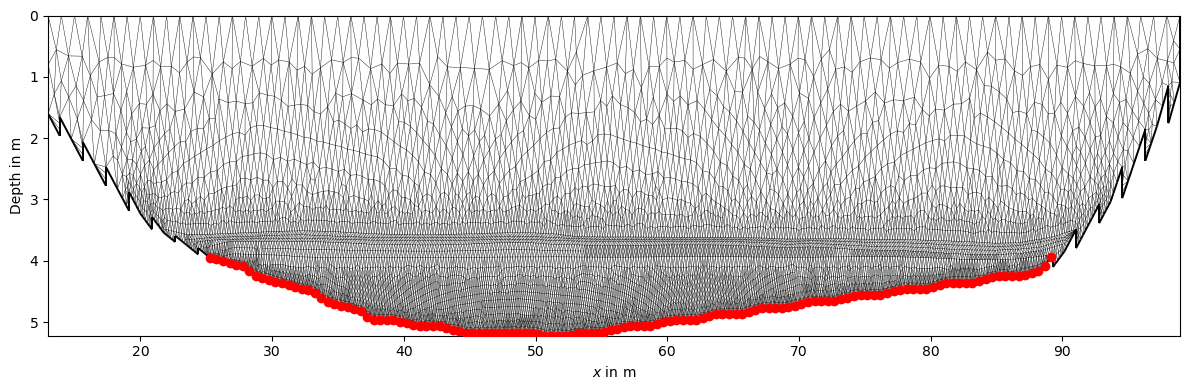

In [7]:
#the original points defining the lower boundary of the domain
points =[(12.99, -1.6041734693877547), (13.867040816326531, -1.6551428571428568), (14.744081632653062, -2.0119285714285713),  (15.621122448979591, -2.0628979591836734), (16.498163265306122, -2.419683673469388), (17.375204081632653, -2.4706530612244895), (18.252244897959184, -2.827438775510204), (19.129285714285714, -2.878408163265306), (20.883367346938776, -3.286163265306122), (21.760408163265307, -3.5410102040816325), (22.637448979591838, -3.5919795918367345), (23.514489795918365, -3.7448877551020407), (24.391530612244896, -3.795857142857143), (25.268571428571427, -3.948765306122449), (26.145612244897958, -3.999734693877551), (27.89969387755102, -4.101673469387755), (28.77673469387755, -4.254581632653061), (29.65377551020408, -4.3055510204081635), (30.530816326530612, -4.356520408163266), (31.407857142857143, -4.407489795918368), (32.284897959183674, -4.45845918367347), (33.16193877551021, -4.509428571428572), (34.038979591836735, -4.662336734693877), (35.7930612244898, -4.764275510204081), (36.67010204081633, -4.815244897959183), (37.54714285714286, -4.9681530612244895), (39.30122448979592, -4.9681530612244895), (40.178265306122455, -5.019122448979592), (41.05530612244898, -5.070091836734694), (42.809387755102044, -5.070091836734694), (43.68642857142858, -5.121061224489796), (44.563469387755106, -5.172030612244898), (46.31755102040817, -5.172030612244898), (48.07163265306123, -5.172030612244898), (49.82571428571429, -5.172030612244898), (50.702755102040825, -5.223), (52.45683673469388, -5.223), (53.333877551020414, -5.172030612244898), (55.08795918367347, -5.172030612244898), (55.965, -5.121061224489796), (56.84204081632653, -5.070091836734694), (58.59612244897959, -5.070091836734694), (59.47316326530613, -5.019122448979592), (60.350204081632654, -4.9681530612244895), (62.104285714285716, -4.9681530612244895), (62.98132653061225, -4.9171836734693875), (63.85836734693878, -4.866214285714285), (65.61244897959183, -4.866214285714285), (66.48948979591836, -4.815244897959183), (67.3665306122449, -4.764275510204081), (69.12061224489796, -4.764275510204081), (69.9976530612245, -4.713306122448979), (70.87469387755102, -4.662336734693877), (72.62877551020408, -4.662336734693877), (73.5058163265306, -4.611367346938775), (74.38285714285715, -4.560397959183673), (76.1369387755102, -4.560397959183673), (77.01397959183673, -4.509428571428572), (77.89102040816326, -4.45845918367347), (79.64510204081633, -4.45845918367347), (80.52214285714285, -4.407489795918368), (81.39918367346938, -4.356520408163266), (83.15326530612245, -4.356520408163266), (84.03030612244898, -4.3055510204081635), (84.9073469387755, -4.254581632653061), (86.66142857142857, -4.254581632653061), (87.5384693877551, -4.203612244897959), (88.41551020408163, -4.152642857142857), (89.29255102040815, -3.897795918367347), (90.1695918367347, -3.846826530612245), (91.04663265306122, -3.4900408163265304),  (91.92367346938775, -3.4390714285714283), (92.80071428571429, -3.0822857142857143), (93.67775510204082, -3.0313163265306122), (94.55479591836735, -2.4706530612244895), (95.43183673469387, -2.419683673469388), (96.3088775510204, -1.859020408163265), (97.18591836734693, -1.808051020408163), (98.06295918367346, -1.1454489795918361), (98.94, -1.0944795918367345)]

spacing = 0.5
number_of_electrodes = 128
electrodes = add_evenly_spaced_points_overall(points, spacing, number_of_electrodes)
print(electrodes)

# Use pg.show() to draw the mesh on the given Matplotlib axis and add electrodes as red circles
fig, ax = plt.subplots(figsize=(12, 4))
pg.show(mesh_6l, ax=ax, showBoundary=True, aspect=aspect)
ax.scatter(np.array(electrodes)[:, 0], np.array(electrodes)[:, 1], color='red', marker='o', label='Electrodes', zorder=10)


### Dipole Dipole

The scheme is built-in and data is created using the dipole-dipole scheme for both geometries. Next, the simulated data is inverted using a clean inversion mesh.

In [ ]:
scheme_dd = ert.createData(elecs=electrodes, schemeName='slm')
scheme_gr = ert.createData(elecs=electrodes, schemeName='slm')
simdata_dd_6l = ert.simulate(mesh=mesh_6l, scheme=scheme_dd, res=K_6l, noiseLevel=0.01, noiseAbs=1e-10, seed=1337)
ert.show(simdata_dd_6l)
simdata_dd_6l.remove(simdata_dd_6l['rhoa'] < 0)
inversion_dd_6 = inversion(simdata_dd_6l, mesh, saveresult=False)

30/12/24 - 20:56:08 - pyGIMLi - INFO - Data error estimate (min:max)  0.010000000214000847 : 0.010000048350821392
30/12/24 - 20:56:09 - pyGIMLi - INFO - Found 1 regions.
30/12/24 - 20:56:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
30/12/24 - 20:56:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
30/12/24 - 20:56:10 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 18637 Cells: 35560 Boundaries: 27526
30/12/24 - 20:56:11 - pyGIMLi - INFO - Use median(data values)=3.3973415596817977
30/12/24 - 20:56:11 - pyGIMLi - INFO - Created startmodel from forward operator: 8890, min/max=3.397342/3.397342
30/12/24 - 20:56:11 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002B512A2A160>
Data transformation: <pgcore.libs._pygimli_.RTransLogLU object at 0x000002B520BB64D0>
Model transformation: <pgcore.libs._pygimli_.RTransLog object at 0x000002B51F5BD710>
min/max (data): 0.6/14.06
min/max (error): 1%/1%
min/max (start model): 3.4/3.4
--------------------------------------------------------------------------------


In [ ]:
pg.show(mesh, data=inversion_dd_6.model, highlight=electrodes, figsize=figsize, aspect=aspect, cMin=cmin, cMax=cmax, cMap=cmap)

### The inversion of a homegeneous fresh water column is added to check how well this is resolved
- the first plot shows this with the same color plot as used for the 6 layer model
- the second plot can be used to look at the errors encountered: this seems to be  +/-  0.4 ohm-m (2.3 - 3.1 ohm-m where 2.7 ohm-m was put in) 

In [ ]:
scheme_dd = ert.createData(elecs=electrodes, schemeName='wa')
simdata_dd_1l = ert.simulate(mesh=mesh_1l, scheme=scheme_dd, res=K_1l, noiseLevel=0.01, noiseAbs=1e-6, seed=1337)
simdata_dd_1l.remove(simdata_dd_1l['rhoa'] < 0)
inversion_dd_1 = inversion(simdata_dd_1l, mesh, saveresult=False)

In [ ]:

pg.show(mesh, data=inversion_dd_1.model, figsize=figsize, aspect=aspect, cMin=cmin, cMax=cmax, cMap=cmap)
pg.show(mesh, data=inversion_dd_1.model, figsize=figsize, aspect=aspect, cMin=1.5, cMax=3.5, cMap='tab10')